In [ ]:
import numpy as np
import scipy.optimize
from scipy.signal import peak_widths
from tqdm import tqdm
from math import sqrt,exp
from functools import partial
import random
from time import time
import matplotlib
from matplotlib import pyplot as plt
from multiprocessing import Pool
from itertools import product
from itertools import combinations
!pip install qutip
from qutip import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from string import ascii_lowercase
settings.num_cpus = 100
font = {'size'   : 17}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 10, 8
plt.rcParams['figure.dpi'] = 90
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.which'] = "both"
props = dict(boxstyle='round', alpha=0.1)

## Hamiltonian

$$
H = \underbrace{\epsilon_d \hat n_d + U \hat n_{d \uparrow} \hat n_{d \downarrow}}_\text{impurity levels} + \overbrace{V\sum_\sigma\left(c^\dagger_{d\sigma}c_{0\sigma} + \text{h.c.}\right)}^{\text{hybridisation of impurity-levels}\atop{\text{with c-bath}}} + \underbrace{\sum_{k\sigma}\epsilon_k \hat n_{k\sigma}}_\text{c-bath kinetic energy}
$$

### Creating Hamiltonian using QuTiP

This is the method that is actually used in this notebook. The python library QuTiP provides objects for the creation and annihilation operators. The Hamiltonian is created by combining these operators. For example, the term $c^\dagger_1 c^\dagger_2 c_3 c_4$ can be written as  ```tensor(create(2), create(2), destroy(2), destroy(2))```. The function ```tensor()``` combines the four operators into a tensor product, and the argument (2) indicates the operators correspond to a particle with a 2-dimensional Hilbert space (the Fock space of a single electron).

In [ ]:
def get_ham(Ek_0, V, ed, U):
    '''
    Create Hamiltonian by joining three parts. First part is the impurity diagonal part, H_d.
    Next is the bath diagonal part, H_k. The third part is the hybridisation, H_v.
    Ek_0 is the conduction electron dispersion. V is the hybridisation coupling.
    ed and U are the impurity parameters. Function returns a Hamiltonian object.
    '''
    
    H_d = 0
    H_k = 0
    H_v = 0
    dim = len(Ek_0)               # number of conduction electrons
    numop = create(2)*destroy(2)  # define a numver operator for later use
    cop = destroy(2)              # shorthand for the annihilation operator
    
    H_d += ed*tensor([numop, identity(2)] + [identity(2)]*2*dim) # impurity onsite enery for spin up
    H_d += ed*tensor([identity(2), numop] + [identity(2)]*2*dim) # impurity onsite enery for spin down
    H_d += U*tensor([numop, numop] + [identity(2)]*2*dim)        # impurity onsite repulsion
    
    for i in range(dim):          # loop over the conduction electron states
        rem = (dim - i - 1)       
        
        # Add the spin up and spin down kinetic energies, for the ith electron
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [numop, identity(2)] + [identity(2)]*2*rem))
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), numop] + [identity(2)]*2*rem))
        
        # Add the hybridisation between impurity and the ith electron, for both spins
        H_v += V * tensor([cop.dag(), identity(2)] + [identity(2)]*2*i + [cop, identity(2)] + [identity(2)]*2*rem)
        H_v += V * tensor([identity(2), cop.dag()] + [identity(2)]*2*i + [identity(2), cop] + [identity(2)]*2*rem)
    
    return H_d + H_k + H_v + H_v.dag()    # make sure to take the h.c. of the hybridisation (.dag())

### $T=0$ Spectral function

The spectral function will now be calculated using the spectral representation:
$$
	G_{dd}^\sigma(\omega, T \to 0) = \sum_{n}\left[||\langle{GS}|c_{i\sigma}|{n}\rangle||^2\frac{1}{\omega + E_{GS} - E_n} + ||\langle{n}|c_{i\sigma}|{GS}\rangle||^2\frac{1}{\omega + E_n - E_{GS}}\right]\\
$$
where the sum $n$ is over the exact eigenstates of the Hamiltonian, and $E_\text{GS}, E_n$ are the energies of the ground state $|GS\rangle$ and excited state $|n\rangle$ respectively.

The next cell provides some helper functions to modularize the process, while the cell next to that performs the actual calculation.

In [30]:
def get_rho_X(args):
    '''
    args = (En, Xn), Xgs, Egs, Z, hfactor, flag
    (En, Xn) - pair of eigenvalue and correspondin eigenstate
    Xgs, Egs - groundstate and its energy, Z = gstate degeneracy
    hfactor - correction factor to ensure height of central peak remains invariant under changes in U.
    This correction factor is applied only on the inner part of the spectral function.
    flag - boolean to detect whether I want to apply the correction factor or not
    Function returns the spectral function contribution coming from a particular term in the summation (En, |n>)
    '''
    
    (En, Xn), Xgs, Egs, Z, hfactor, flag = args
    
    c0_up = tensor([identity(2), destroy(2)] + [identity(2)]*(len(Xgs.dims[0])-2))    # annihilation operator for the imp down electron
    
    # spectral weights ||<Gs|c|n>||^2 and ||<n|c|GS>||^2
    C1 = Xgs.dag()*c0_up*Xn
    C1_sq = np.real((C1*C1.dag())[0][0][0])
    C2 = Xn.dag()*c0_up*Xgs
    C2_sq = np.real((C2*C2.dag())[0][0][0])
    
    # broadening of the Gaussian used to convert the delta functions into 
    # smooth functions (the spectral function for a discrete system will have 
    # a sum over delta functions. To match with the thermodynamic limit or experiments,
    # these delta functions have to converted into some conitnuous function like
    # Gaussian or Lorentzian)
    
#     eta = Delta + 0.5*abs(En - Egs)
    delta = get_delta(V,t)
    eta = 2*delta + abs(En - Egs)/2
    # this broadening has been chosen so as to 
    # match up with the U=0 case (single Lorentzian, no side bands)

    
    # these are the denominators: 
    # w + E_GS - En and w - E_GS + En
    x1 = w_range + Egs - En
    x2 = w_range + En - Egs
    
    
    # if flag is True, do not apply any correction factor, just compute the term 
    # inside the summation of the spectral representation and also return the 
    # position of the pole, En - Egs
    # If flag is False, do apply the correction factor in the Gaussian broadening
    # parameter eta, then compute the term inside the summation and finally return
    # this term.
    if flag == True:       
        return En - Egs, (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
    else:
        if abs(En - Egs) < w_cut:
            eta /= hfactor
        return (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z

    
    
def get_nonint_ht_and_w_cut(Ek_0, V, tqdm_flag=False):
    '''
    Returns the height of the non-interacting 
    resonant level model (U=0), and the midpoint
    of the poles on one side. The non-int-ht is 
    required to fix the height for non-zero values
    of U. Ek_0 contains the dispersion. V is the 
    hybridisation. tqdm_flag controls whether to 
    display a progress bar or not.
    '''
    
    U = 0
    ed = -U/2    # p-h symmetry
    H = get_ham(Ek_0, V, ed, U)    # obtain the Hamiltonian, given the parameterss U,ed,Ek_0,V
    H = 0.5 * (H + H.dag())        # make sure H is Hermitian
    E, X = H.eigenstates()         # qutip function to calculate eigenvalues and eigenstates
    X0 = X[np.where(E == min(E))]  # get full set of degenerate ground states
    
    # get spectral function and symmetrize about w=0
    A = 0
    poles = []
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [1], [True])
    for pi, Ai in list(tqdm(Pool().map(get_rho_X, args), disable=tqdm_flag, total=len(X0)*len(E))):
        A += Ai
        poles.append(pi)
        
    A = 0.5*(A + np.flip(A))

    # return the height at zero frequency
    return A[np.where(w_range == 0)], (poles[-1] - poles[0])/50
    
    

def spec_func_solve(args, x):
    E, X, X0, h = args
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [x], [False])    
    
    # loop over all excited states and pass each state to the spectral function
    # calculator to get the spectral weights for all poles individually
    # pi loops over the positions of the poles, while Ai is the spectral function
    # due solely to that pool. The total spectral function is just sum_i A_i
    A = sum(Pool().map(get_rho_X, args))
    A = 0.5*(A + np.flip(A))
    return A[np.where(w_range == 0)] - h
    
def get_correction_factor(E, X, h, tqdm_flag=False):
    '''
    Returns the correction factor necessary to ensure height at 
    U != 0 remains fixed at that of the U=0 case. E,X is the full 
    spectrum of H. h is the height at U=0. The correction factor
    is calculated using the equation h = hfactor x wt_inner + wt_outer.
    wt_inner is the spectral weight at w=0 coming from the inner poles,
    while wt_outer is the same due to the outer poles. These spectral 
    weights are obtained by running through the spectral function 
    calculating function once.
    '''
    X0 = X[np.where(E == min(E))]     # set of degenerate ground states
    wt = np.zeros(2)    # array of two elements, stores wt_inner and wt_outer

    # arguments to be passed to the spectral function calculator
    # for calculating the spectral weights inner and outer
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [1], [True])    
    
    # loop over all excited states and pass each state to the spectral function
    # calculator to get the spectral weights for all poles individually
    # pi loops over the positions of the poles, while Ai is the spectral function
    # due solely to that pool. The total spectral function is just sum_i A_i
    for pi, Ai in list(tqdm(Pool().map(get_rho_X, args), disable=tqdm_flag, total=len(X0)*len(E))):

        # if the pole position is less than a pre-chosen cutoff, 
        # count it as part of wt_inner, esle wt_outer
        wt[int(pi > w_cut)] += Ai[np.where(w_range == 0)]
    
    hfactor = (abs(h - wt[1])/wt[0])[0]
    args = (E, X, X0, h)
    func_partial = partial(spec_func_solve, args)
    hfactor = scipy.optimize.newton_krylov(func_partial, round(hfactor, 3))
    return hfactor



def get_FWHM(w_range, A):
    '''
    calculates the full width at half maximum
    of the central peak, given an x-domain w_range
    and a spectral function A
    '''
    w_half = w_range[(A <= max(A)) & (A>=max(A)/2)]
    return (max(w_half) - min(w_half))
    

    
def spec_func_U(U, Ek_0, V, non_int_ht, tqdm_flag=False):
    '''manager function to calculate spectral function, 
    given the model parameters and the non interacting 
    resonant level model height. First obtains eigenstates
    by diagonalization, then calculates correction factor,
    and finally obtains spectral function after applying this
    correction  factor. Also symmetrizes it about w=0.'''
    
    ed = -U/2    # p-hole symmetry
    H = get_ham(Ek_0, V, ed, U)    # obtains Hamiltonian for the given values of U, ed, V, Ek
    H = 0.5 * (H + H.dag())    # make sure its Hermitian
    E, X = H.eigenstates()    # diagonalize. E=eigenvalues,X=eigenstates
    X0 = X[np.where(E == min(E))]    # set of degenerate ground states
    hfactor = get_correction_factor(E, X, non_int_ht, tqdm_flag=tqdm_flag)    # obtain correction factor
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [hfactor], [False])    # args to pass to the spectral function calculator

    # obtain the spectral function from individual poles, then sum them to get entire spec. func
    A = sum(list(tqdm(Pool().map(get_rho_X, args), disable=tqdm_flag, total=len(X0)*len(E))))
    A = 0.5*(A + np.flip(A))    # symmetrize about w=0
    return A



def create_axes(len_U):
    '''
    create matplotlib axes to draw the plots,
    no physics here
    '''
    fig1, ax1 = plt.subplots(len_U, figsize=(20,9*len_U))
    ax1_in = []
    for i, ax in enumerate(ax1):
        ax.set_xlabel(r"$\omega/\Delta$")
        ax.set_ylabel(r"$A_d(\omega)$")
        ax.set_title(r"$U/\Delta={}$".format(np.round(U_range[i]/delta),2))
        ax1_in.append([inset_axes(ax, width="40%", height="50%", loc=2), inset_axes(ax, width="40%", height="50%", loc=1)])
        ax1_in[-1][0].axes.get_yaxis().set_visible(False)
        ax1_in[-1][1].axes.get_yaxis().set_visible(False)
    
    fig2, ax2 = plt.subplots(figsize=(14,10))
    ax2.set_xlabel(r"$\omega/\Delta$")
    ax2.set_ylabel(r"$\mathcal{A}(\omega)$")
    ax2_in = inset_axes(ax2, width="40%", height="40%", loc=2)
    ax2_in.axes.get_yaxis().set_visible(False)
    fig3, ax3 = plt.subplots(figsize=(14,10))
    ax3.set_xlabel(r"$\omega/\Delta$")
    ax3.set_ylabel(r"$\mathcal{A}(\omega)$")
    return fig1, ax1, ax1_in, fig2, ax2, ax2_in, fig3, ax3


def get_wrange(w_end, len_w, p=1):
    '''
    create the x-range of frequencies, no physics here
    '''
    w_half = np.linspace(0, w_end, len_w)**p/w_end**(p-1)
    w_range = np.unique(np.concatenate([-w_half, w_half]))
    return w_range

100%|██████████| 2048/2048 [00:00<00:00, 566880.13it/s]
/home/abhirup/miniconda3/lib/python3.9/site-packages/scipy/optimize/nonlin.py:472: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))
100%|██████████| 2048/2048 [00:00<00:00, 523744.56it/s]


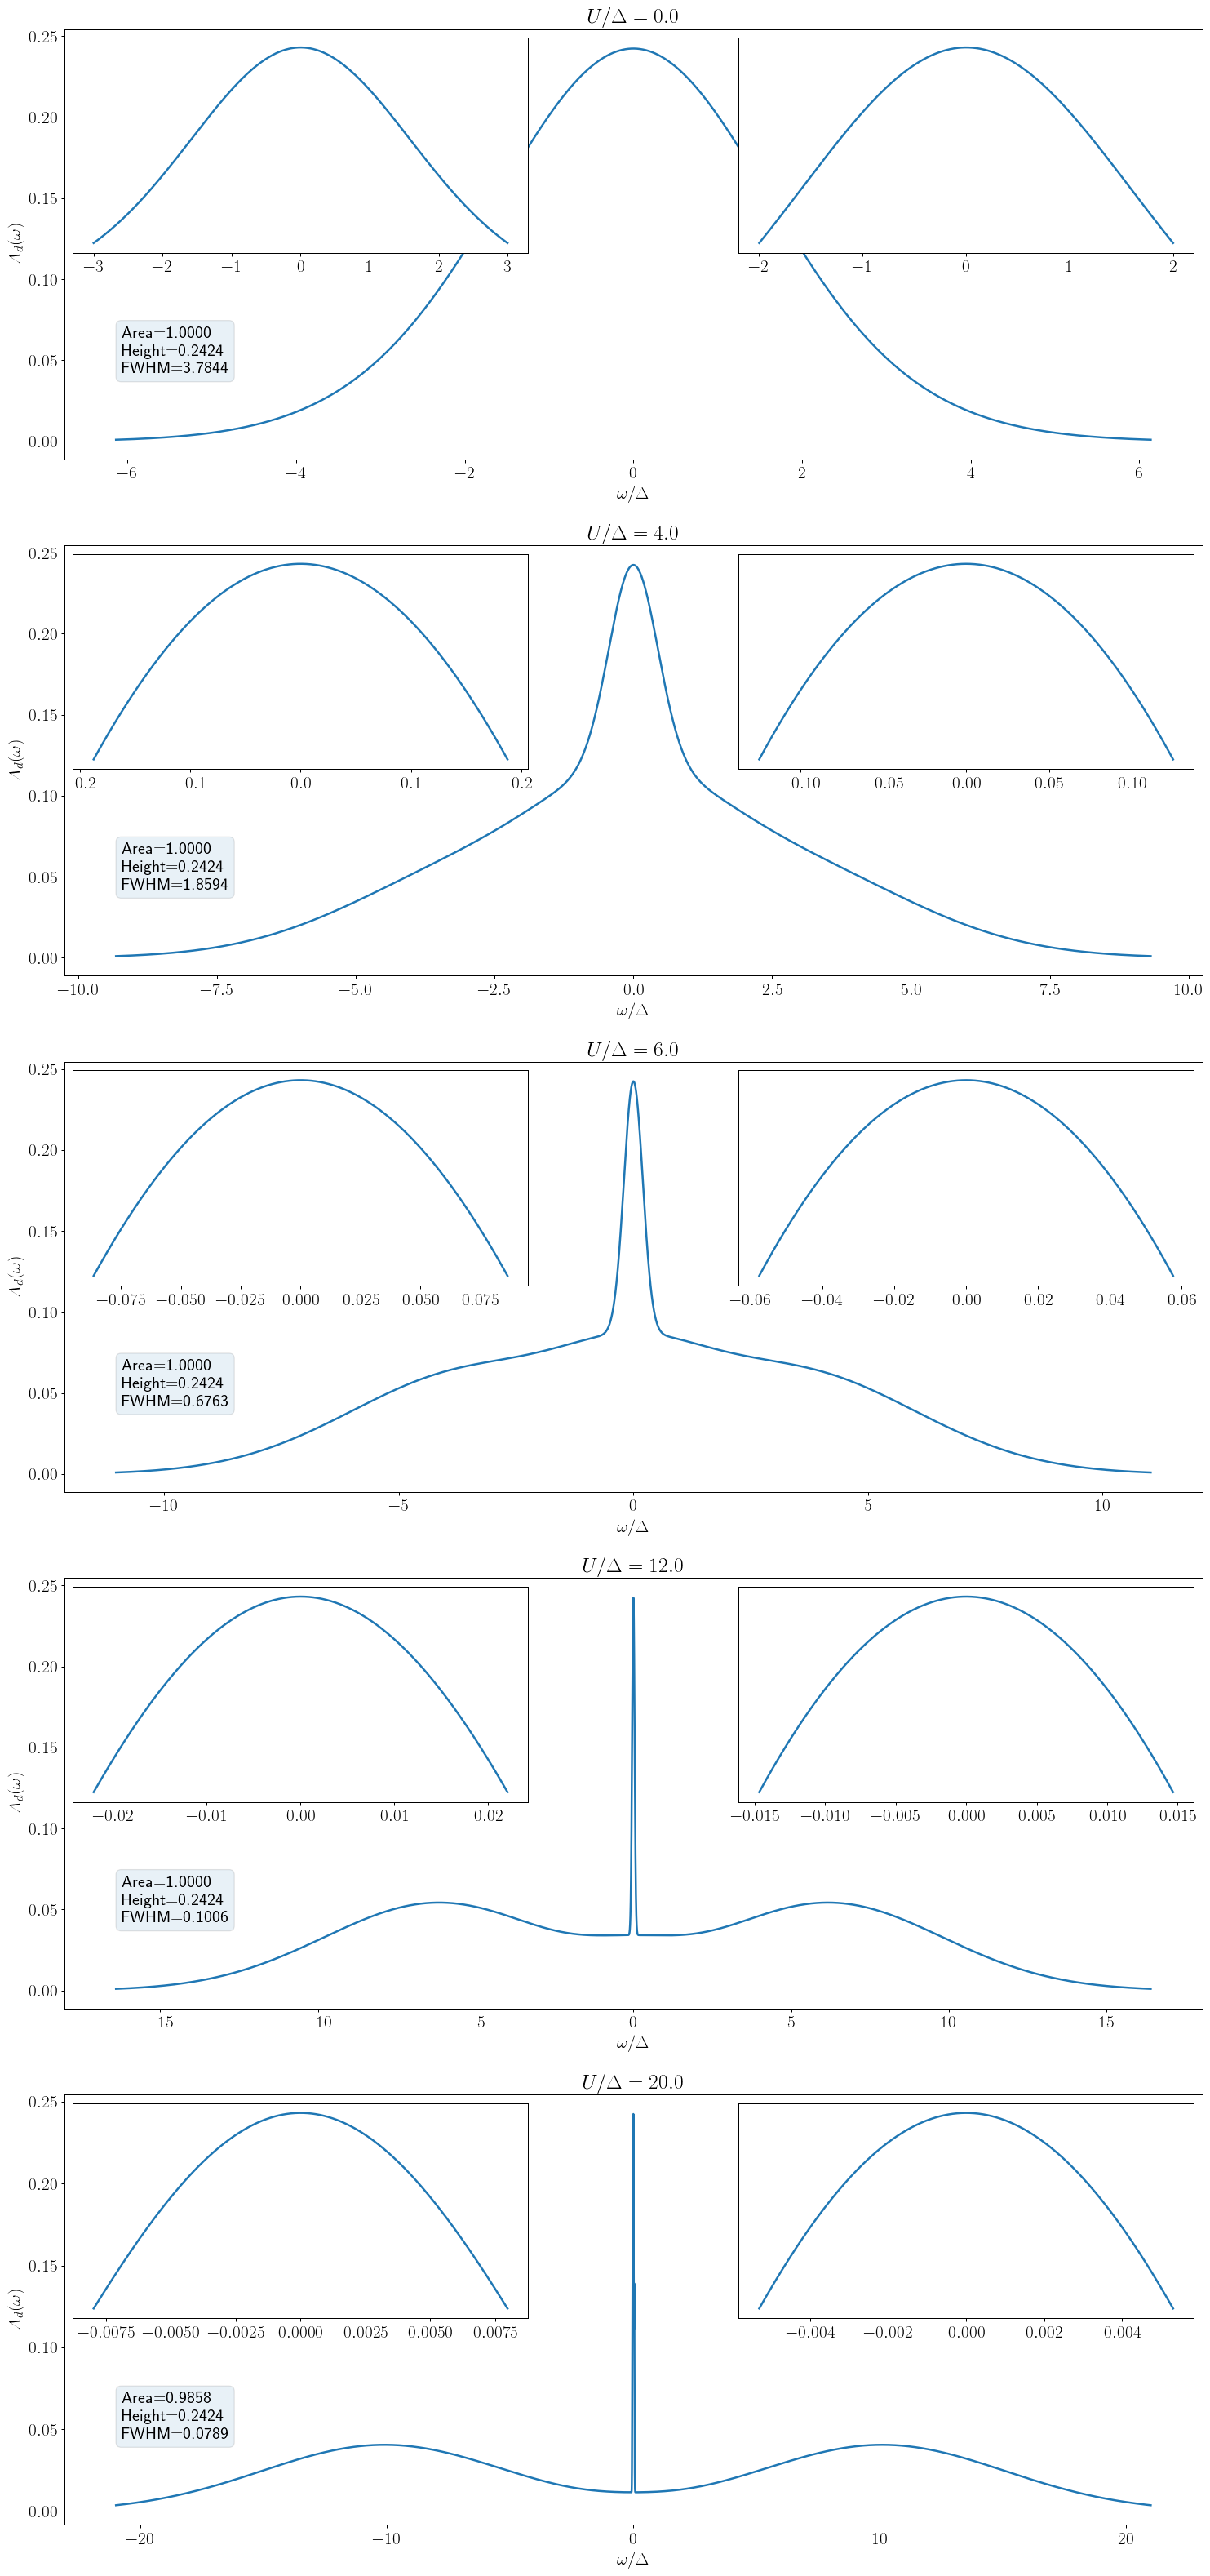

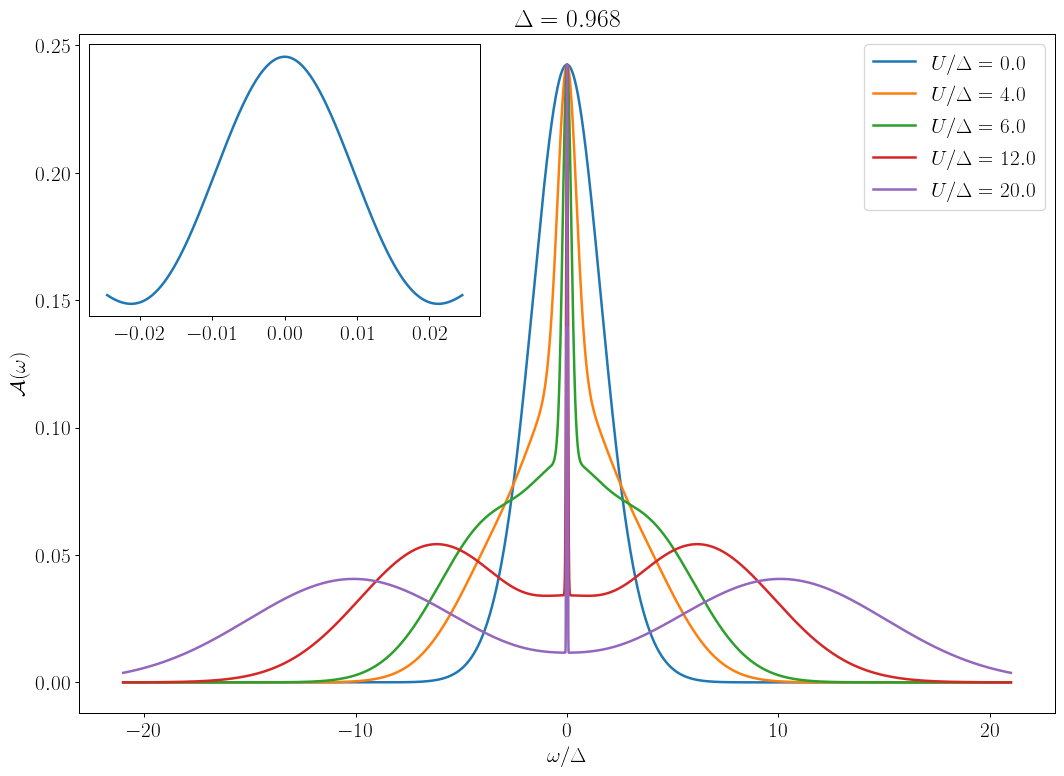

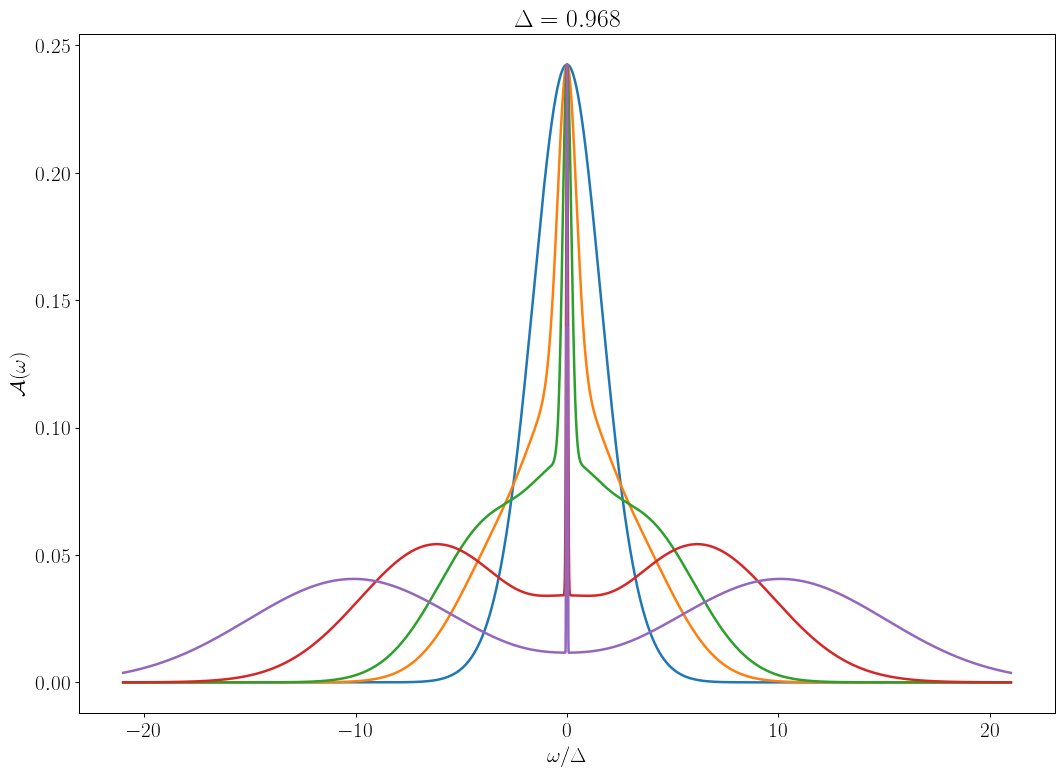

In [36]:
def get_delta(V, t):
    return V**2/t

# choose model parameters
# make sure V > t, because V = sqrt(N)*t

V = 0.22    # hybridisation coupling V sum_k c^dagger_d c_k
t = 0.05    # tight-binding hoppping strength
Nk = 4    # number of k-modes in bath
a = 1    # lattice spacing
k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)    # k_n = 2.pi.n/(N.a)
Ek_0 = -2*t*np.cos(k_bath*a)    # E_k = -2t(cos ka)

w_range = get_wrange(10, 1000, p=1)    # x-range for frequency

# obtain height of spectral function at w=0 for the resonant level model
# w_cut is cut of along x-axis to calculate height correction factor
non_int_ht, w_cut = get_nonint_ht_and_w_cut(Ek_0, V)

# define Delta in terms of this non interacting height,
# using the equation height = 1/(pi. Delta)
delta = get_delta(V,t)

# re-obtain x-range, now in terms of this delta
w_range = get_wrange(21*delta, 10000, p=4)

# define range of U over which to obtain spectra
U_range = np.array([0, 4, 6, 12, 20])*delta

# get set of matplotlib figures to plot onto
fig1, ax1, ax1_in, fig2, ax2, ax2_in, fig3, ax3 = create_axes(len(U_range))

# loop over the list of U, and plot spectral function for each U
for i, (U, ax) in enumerate(zip(U_range, ax1)):
    A = spec_func_U(U, Ek_0, V, non_int_ht)    # get spectral function for this U

    # for noting purposes, calculate the maximum, the total area
    # and the central peak FWHM of the spectral function
    maxA = max(A)
    area = np.trapz(A, w_range)
    fwhm = get_FWHM(w_range, A)
    
    # create a string to display these details
    textstr = '\n'.join((
    r'Area=%.4f' % np.trapz(A, w_range),
    r'Height=%.4f' % max(A),
    r'FWHM=%.4f' % get_FWHM(w_range, A)))

    # this is the x-range over which the spectral function
    # is appreciable. Only this part is plotted.
    prominent_range = np.where(A > 10**(-3))

    # plot the spectral function for various values of U,
    # as well as some zoomed in views in the insets
    ax.plot(w_range[prominent_range]/delta, A[prominent_range])
    ax1_in[i][0].plot(w_range[np.where(abs(w_range/delta) < 3/(1+U**2))]/delta, A[np.where(abs(w_range/delta) < 3/(1+U**2))])
    ax1_in[i][1].plot(w_range[np.where(abs(w_range/delta) < 2/(1+U**2))]/delta, A[np.where(abs(w_range/delta) < 2/(1+U**2))])
    ax.text(0.05, 0.2, textstr, transform = ax.transAxes, size=17, bbox=props, horizontalalignment="left", fontfamily="monospaced")
    ax2.plot(w_range/delta, A, label=r"$U/\Delta={}$".format(round(U/delta,2)))
    if U == U_range[-1]:
        ax2_in.plot(w_range[np.where(abs(w_range/delta) < 0.5/(1+U))]/delta, A[np.where(abs(w_range/delta) < 0.5/(1+U))])
    ax3.plot(w_range/delta, A, label=r"$U/\Delta={}$".format(round(U/delta,2)))


ax2.set_title(r"$\Delta = {}$".format(round(delta,3)))
ax3.set_title(r"$\Delta = {}$".format(round(delta,3)))
ax2.legend()
fig1.savefig("siam_specfunc_separate.pdf", bbox_inches='tight')
fig2.savefig("siam_specfunc_all_inset.pdf", bbox_inches='tight')
fig3.savefig("siam_specfunc_all.pdf", bbox_inches='tight')
plt.show()

## Fit of width vs U curve

Here we try to find an expression for the width as a funtion of $U$, by fitting the width vs U curve to expressions.

In [ ]:
def fit_func(x, A, B, C):
    '''
    simple fitting function
    '''
    return (A + B*x)*np.exp(-C*x)


def fit_func_hrk(x, A, B, C, D, E, F):
    '''
    fitting function with more parameters
    '''
    return x*delta*(A + x**B + np.sin(C+D*x))*np.exp(-E*x**F)


def plot_fit(x, y1, y2, xl=r"$U/\Delta$", yl=r"FWHM", l="", text="", log=False, save=False):
    '''
    plots both the fit curve as well as the 
    actual curve on the same figure.
    '''
    plt.scatter(x, y1, marker=".", color='r', label="data")
    plt.plot(x, y2, label=l)
    ax = plt.gca()
    plt.text(0.05, 0.2, text, transform = ax.transAxes, size=17, bbox=props, horizontalalignment="left", fontfamily="monospaced")
    if log == True:
        plt.yscale("log")
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.legend()
    if save != False:
        plt.savefig(str(save), bbox_inches='tight')
    plt.show()

    
# repeat the same steps as in the previous cell,
# but now solely with the purpose of calculating
# the FWHM for various values of U
V = 0.1
t = 0.05
Nk = 4
a = 1
k_bath = 2*np.pi*np.arange(0, Nk)/(a*Nk)
Ek_0 = -2*t*np.cos(k_bath*a)

w_range = get_wrange(3, 1000, p=4)
w_cut = 10**(-4)
non_int_ht = get_nonint_ht(Ek_0, V, tqdm_flag=True)
delta = float(1/(np.pi * non_int_ht))

U_range = np.arange(0, 5.05, 0.05)
# get the FWHM for various values of U
fwhm_arr = [get_FWHM(w_range, spec_func_U(U, Ek_0, V, non_int_ht, tqdm_flag=True)) for U in tqdm(U_range)]

# obtain the fitting parameters
args = curve_fit(fit_func, U_range, fwhm_arr, maxfev=10000)[0]
print(*args)
names = ascii_lowercase[:len(args)]
textstr = '\n'.join(['%s = %.4f' % (name,arg) for name,arg in zip(names,args)])
fit_arr = [fit_func(U, *args) for U in U_range]
plot_fit(U_range, fwhm_arr, fit_arr, xl=r"$U/\Delta$", yl=r"FWHM", l=r"Fit against $(a + bU)\exp(-cU)$", text=textstr, log=False, save="width_vs_U_simple_fit.pdf")
plot_fit(U_range, fwhm_arr, fit_arr, xl=r"$U/\Delta$", yl=r"FWHM", l=r"Fit against $(a + bU)\exp(-cU)$", text=textstr, log=True, save="width_vs_U_simple_fit_log.pdf")